# Importações

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import sys
import argparse
import cv2
import random
import json
# import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy import ndimage
from tensorflow.python.client import device_lib
# from PIL import Image

In [28]:
!python -m pip install -U matplotlib

# Checa se a GPU está sendo usada

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Variáveis Globais

In [2]:
train_size        = 185 * 2 # Tamanho dos dados para treinamento
test_size         = 40 # Tamanho dos dados para teste
max_vid_per_class = 100 # Número máximo de vídeos por classe
batch_size        = train_size + test_size # Tamanho total dos dados de treinamento e validação 577
num_of_frames     = 12  # Número de frames que o vídeo será dividido
width             = 64  # Largura da imagem
height            = 48  # Altura da imagem
num_of_channels   = 1   # Número de canais da imagem (cinza, RGB, etc.)
num_of_classes    = 10  # Número de classes que serão utilizadas
test_percentage   = 0.2 # Porcentagem utilizada para a qtd de dados para teste

# Classes (Apenas Vídeo)

In [48]:
class_names = {
    "Acontecer"   : 0, 
    "Aluno"       : 1, 
    "Amarelo"     : 2, 
    'America'     : 3, 
    'Aproveitar'  : 4,
    "Bala"        : 5, 
    "Banco"       : 6, 
    "Banheiro"    : 7, 
    "Barulho"     : 8, 
    "Cinco"       : 9,
    "Conhecer"    : 10, 
    "Espelho"     : 11, 
    "Esquina"     : 12, 
    "Filho"       : 13, 
    "Maca"        : 14, 
    "Medo"        : 15,
    "Ruim"        : 16, 
    "Sapo"        : 17, 
    "Vacina"      : 18, 
    "Vontade"     : 19
}

# Classes (Apenas Imagens)

In [4]:
class_names = {
    "A"   : 0,
    "B"   : 1,
    "C"   : 2,
    "D"   : 3,
    "E"   : 4
}

# Classes (Vídeos e Imagens)

In [3]:
class_names = {
    "A"           : 0,
    "Acontecer"   : 1, 
    "Aluno"       : 2, 
    "Amarelo"     : 3, 
    'America'     : 4, 
    'Aproveitar'  : 5,
    "B"           : 6,
    "C"           : 7,
    "D"           : 8,
    "E"           : 9
}

# Transformação dos vídeos e imagens para treinamento e teste (junto)

In [8]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

X_data = [] # armazena os frames
Y_data = [] # armazena as labels

video_type = '.mp4'

angles = [-20, -10, -5, 5, 10, 20] # Define alguns ângulos para rotação

video_classes   = './LIBRAS-Dataset-Definitivo/' # caminho da pasta com os arquivos
list_of_classes = os.listdir(video_classes) # pega o nome de todos os arquivos dentro da pasta
print(list_of_classes)

class_counter = 0
for k in list_of_classes:
    if (class_counter >= num_of_classes):
        break
    
    class_counter = class_counter + 1
    
    X_dummy = []
    Y_dummy = []
    
    video_folder   = str(video_classes + k + '/')
    list_of_videos = os.listdir(video_folder)
    
    contador = 0
    
    print('\n===== ' + k + ' =====\n')
    
    # pega o nome de cada arquivo de vídeo e passa para transformar em frames
    for i in list_of_videos:
        if contador >= max_vid_per_class:
            print('\n\n===== FIM DA CLASSE =====\n')
            break
            
        contador = contador + 1
        
        isVideo = False
        
        if video_type in i:
            isVideo = True
            
        if (isVideo):
            vid = str(video_folder + i) # caminho do vídeo
            cap = cv2.VideoCapture(vid) # lê o vídeo
            
            # pega o tamanho do vídeo em milisegundos e divide pela
            # quantidade de frames para descobrir o tempo que deve ser
            # pego cada frame
            fps          = cap.get(cv2.CAP_PROP_FPS)
            frame_count  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration     = frame_count/fps
            seconds      = frame_count/fps;
            miliseconds  = seconds * 1000
            frame_moment = int(miliseconds/num_of_frames)
        else:
            vid = str(video_folder + i) # caminho do arquivo
            cap = cv2.imread(vid) # lê o arquivo   
        
        frames        = [] # armazenar os frames
        #rotatedFrames = [] # armazenar os frames distorcidos
        
        count = 0 # contador para pegar cada frame
        
        #angle = random.choice(angles) # escolhe aleatóriamente um ângulo
        for j in range(num_of_frames): # aqui pegamos n frames de acordo com num_of_frames
            
            if (isVideo):
                cap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_moment)) # seta o momento do vídeo para pegar o frame
                ret, frame = cap.read() # pega de fato o frame, e se deu sucesso ou não
            
                if ret == True: # se deu sucesso...
                    print('S=>', end="")
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
                    frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
                    frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
                    #rotatedFrame = ndimage.rotate(frame, angle, reshape=False)
                    #rotatedFrames.append(rotatedFrame)
                else:
                    print('*E*=>', end="")
            else:
                print('S=>', end="")

                frame = cv2.cvtColor(cap, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
                frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
                frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
                
            count = count + 1
            
        X_dummy.append(frames) # adiciona todos os frames de um vídeo
        Y_dummy.append(class_names[k]) # adiciona a label do conjunto de frames
    
    X_data.append(X_dummy)
    Y_data.append(Y_dummy)
    #X_data.append(rotatedFrames) # adiciona todos os frames de um vídeo
    #Y_data.append(class_names[k]) # adiciona a label do conjunto de frames
    
print('\n\n===== FIM =====\n\n')

['A', 'Acontecer', 'Aluno', 'Amarelo', 'America', 'Aproveitar', 'B', 'C', 'D', 'E']

===== A =====

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S

# Transformação das imagens para treinamento e teste (junto)
- Aqui é pego todos os dados juntos, para que a separação entre treino e teste possa ser feita depois

In [5]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

X_data = [] # armazena os frames
Y_data = [] # armazena as labels

angles = [-20, -10, -5, 5, 10, 20] # Define alguns ângulos para rotação

video_classes   = './LIBRAS-Dataset-Images/' # caminho da pasta com os arquivos
list_of_classes = os.listdir(video_classes) # pega o nome de todos os arquivos dentro da pasta
print(list_of_classes)

class_counter = 0
for k in list_of_classes:
    if (class_counter >= num_of_classes):
        break
    
    class_counter = class_counter + 1
    
    X_dummy = []
    Y_dummy = []
    
    video_folder   = str(video_classes + k + '/')
    list_of_videos = os.listdir(video_folder)
    
    contador = 0
    
    print('\n===== ' + k + ' =====\n')
    
    # pega o nome de cada arquivo de vídeo e passa para transformar em frames
    for i in list_of_videos:
        if contador >= max_vid_per_class:
            print('\n\n===== FIM DA CLASSE =====\n')
            break
            
        contador = contador + 1
        
        vid = str(video_folder + i) # caminho do vídeo
        cap = cv2.imread(vid) # lê o vídeo
        
        # pega o tamanho do vídeo em milisegundos e divide pela
        # quantidade de frames para descobrir o tempo que deve ser
        # pego cada frame
#         fps          = cap.get(cv2.CAP_PROP_FPS)
#         frame_count  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         duration     = frame_count/fps
#         seconds      = frame_count/fps;
#         miliseconds  = seconds * 1000
#         frame_moment = int(miliseconds/num_of_frames)
        
        frames        = [] # armazenar os frames
#         rotatedFrames = [] # armazenar os frames distorcidos
        
        count = 0 # contador para pegar cada frame
        
        angle = random.choice(angles) # escolhe aleatóriamente um ângulo
        for j in range(num_of_frames): # aqui pegamos n frames de acordo com num_of_frames
#             cap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_moment)) # seta o momento do vídeo para pegar o frame
#             ret, frame = cap.read() # pega de fato o frame, e se deu sucesso ou não
            
#             if ret == True: # se deu sucesso...
            print('S=>', end="")

            frame = cv2.cvtColor(cap, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
            frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
            frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
            #rotatedFrame = ndimage.rotate(frame, angle, reshape=False)
            #rotatedFrames.append(rotatedFrame)
                
#             else:
#                 print('*E*=>', end="")
                
            count = count + 1
            
        X_dummy.append(frames) # adiciona todos os frames de um vídeo
        Y_dummy.append(class_names[k]) # adiciona a label do conjunto de frames
    
    X_data.append(X_dummy)
    Y_data.append(Y_dummy)
    #X_data.append(rotatedFrames) # adiciona todos os frames de um vídeo
    #Y_data.append(class_names[k]) # adiciona a label do conjunto de frames
    
print('\n\n===== FIM =====\n\n')

['A', 'B', 'C', 'D', 'E']

===== A =====

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S

# Transformação dos frames de vídeos para treinamento e teste (junto)
- Aqui é pego todos os dados juntos, para que a separação entre treino e teste possa ser feita depois

In [8]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

X_data = [] # armazena os frames
Y_data = [] # armazena as labels

angles = [-20, -10, -5, 5, 10, 20] # Define alguns ângulos para rotação

video_classes   = './LIBRAS-Dataset/Treino/' # caminho da pasta com os arquivos
list_of_classes = os.listdir(video_classes) # pega o nome de todos os arquivos dentro da pasta
print(list_of_classes)

class_counter = 0
for k in list_of_classes:
    if (class_counter >= num_of_classes):
        break
    
    class_counter = class_counter + 1
    
    X_dummy = []
    Y_dummy = []
    
    video_folder   = str(video_classes + k + '/')
    list_of_videos = os.listdir(video_folder)
    
    contador = 0
    
    print('\n===== ' + k + ' =====\n')
    
    # pega o nome de cada arquivo de vídeo e passa para transformar em frames
    for i in list_of_videos:
        if contador >= max_vid_per_class:
            print('\n\n===== FIM DA CLASSE =====\n')
            break
            
        contador = contador + 1
        
        vid = str(video_folder + i) # caminho do vídeo
        cap = cv2.VideoCapture(vid) # lê o vídeo
        
        # pega o tamanho do vídeo em milisegundos e divide pela
        # quantidade de frames para descobrir o tempo que deve ser
        # pego cada frame
        fps          = cap.get(cv2.CAP_PROP_FPS)
        frame_count  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration     = frame_count/fps
        seconds      = frame_count/fps;
        miliseconds  = seconds * 1000
        frame_moment = int(miliseconds/num_of_frames)
        
        frames        = [] # armazenar os frames
        rotatedFrames = [] # armazenar os frames distorcidos
        
        count = 0 # contador para pegar cada frame
        
        angle = random.choice(angles) # escolhe aleatóriamente um ângulo
        for j in range(num_of_frames): # aqui pegamos n frames de acordo com num_of_frames
            cap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_moment)) # seta o momento do vídeo para pegar o frame
            ret, frame = cap.read() # pega de fato o frame, e se deu sucesso ou não
            
            if ret == True: # se deu sucesso...
                print('S=>', end="")
                
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
                frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
                frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
                #rotatedFrame = ndimage.rotate(frame, angle, reshape=False)
                #rotatedFrames.append(rotatedFrame)
                
            else:
                print('*E*=>', end="")
                
            count = count + 1
            
        X_dummy.append(frames) # adiciona todos os frames de um vídeo
        Y_dummy.append(class_names[k]) # adiciona a label do conjunto de frames
    
    X_data.append(X_dummy)
    Y_data.append(Y_dummy)
    #X_data.append(rotatedFrames) # adiciona todos os frames de um vídeo
    #Y_data.append(class_names[k]) # adiciona a label do conjunto de frames
    
print('\n\n===== FIM =====\n\n')

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: './LIBRAS-Dataset/Treino/'

# Transformação dos frames de vídeos para treino (separado)

In [64]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

X_data_train = [] # armazena os frames
Y_data_train = [] # armazena as labels
angles = [-20, -10, -5, 5, 10, 20] # Define alguns ângulos para rotação

video_classes   = './LIBRAS-Dataset-2/Treino/' # caminho da pasta com os arquivos
list_of_classes = os.listdir(video_classes) # pega o nome de todos os arquivos dentro da pasta
print(list_of_classes)

class_counter = 0
for k in list_of_classes:
    if (class_counter >= num_of_classes):
        break
        
    class_counter = class_counter + 1
    
    video_folder   = str(video_classes + k + '/')
    list_of_videos = os.listdir(video_folder)
    
    contador = 0
    
    print('\n===== ' + k + ' =====\n')
    
    # pega o nome de cada arquivo de vídeo e passa para transformar em frames
    for i in list_of_videos:
        if contador >= max_vid_per_class:
            print('\n\n===== FIM DA CLASSE =====\n')
            break
            
        contador = contador + 1
        
        vid = str(video_folder + i) # caminho do vídeo
        cap = cv2.VideoCapture(vid) # lê o vídeo
        
        # pega o tamanho do vídeo em milisegundos e divide pela
        # quantidade de frames para descobrir o tempo que deve ser
        # pego cada frame
        fps          = cap.get(cv2.CAP_PROP_FPS)
        frame_count  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration     = frame_count/fps
        seconds      = frame_count/fps;
        miliseconds  = seconds * 1000
        frame_moment = int(miliseconds/num_of_frames)
        
        frames        = [] # armazenar os frames
        rotatedFrames = [] # armazenar os frames distorcidos
        
        count = 0 # contador para pegar cada frame
        
        angle = random.choice(angles) # escolhe aleatóriamente um ângulo
        
        for j in range(num_of_frames): # aqui pegamos n frames de acordo com num_of_frames
            cap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_moment)) # seta o momento do vídeo para pegar o frame
            ret, frame = cap.read() # pega de fato o frame, e se deu sucesso ou não
            
            if ret == True: # se deu sucesso...
                print('S=>', end="")
                
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
                frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
                frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
                rotatedFrame = ndimage.rotate(frame, angle, reshape=False)
                rotatedFrames.append(rotatedFrame.tolist())
                
            else:
                print('*E*=>', end="")
                
            count = count + 1
            
        X_data_train.append(frames) # adiciona todos os frames de um vídeo
        Y_data_train.append(class_names[k]) # adiciona a label do conjunto de frames
        X_data_train.append(rotatedFrames) # adiciona todos os frames de um vídeo
        Y_data_train.append(class_names[k]) # adiciona a label do conjunto de frames
        
print('\n\n===== FIM =====\n\n')

['Acontecer', 'Aluno', 'Amarelo', 'America', 'Aproveitar', 'Bala', 'Banco', 'Banheiro', 'Barulho', 'Cinco', 'Conhecer', 'Espelho', 'Esquina', 'Filho', 'Maca', 'Medo', 'Ruim', 'Sapo', 'Vacina', 'Vontade']

===== Acontecer =====

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S

# Transformação dos frames de vídeos para teste (separado)

In [66]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

X_data_test = [] # armazena os frames
Y_data_test = [] # armazena as labels

video_classes   = './LIBRAS-Dataset-2/Teste/' # caminho da pasta com os arquivos
list_of_classes = os.listdir(video_classes) # pega o nome de todos os arquivos dentro da pasta
print(list_of_classes)

class_counter = 0

for k in list_of_classes:
    if (class_counter >= num_of_classes):
        break
        
    class_counter = class_counter + 1
    
    video_folder   = str(video_classes + k + '/')
    list_of_videos = os.listdir(video_folder)
    
    contador = 0
    
    print('\n===== ' + k + ' =====\n')
    
    # pega o nome de cada arquivo de vídeo e passa para transformar em frames
    for i in list_of_videos:
        if contador >= max_vid_per_class:
            print('\n\n===== FIM DA CLASSE =====\n')
            break
            
        contador = contador + 1
        
        vid = str(video_folder + i) # caminho do vídeo
        cap = cv2.VideoCapture(vid) # lê o vídeo
        
        frames = [] # armazenar os frames
        
        count = 0 # contador para pegar cada frame
        
        for j in range(num_of_frames): # aqui pegamos n frames de acordo com num_of_frames
            cap.set(cv2.CAP_PROP_POS_MSEC,(count*250)) # seta o momento do vídeo para pegar o frame
            ret, frame = cap.read() # pega de fato o frame, e se deu sucesso ou não
            
            if ret == True: # se deu sucesso...
                print('S=>', end="")
                
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converte o frame para cinza
                frame = cv2.resize(frame,(width,height),interpolation=cv2.INTER_AREA) # redimensiona o frame
                frames.append(frame.tolist()) # adiciona o frame para o vetor de frames
                
            else:
                print('*E*=>', end="")
                
            count = count + 1
            
        X_data_test.append(frames) # adiciona todos os frames de um vídeo
        Y_data_test.append(class_names[k]) # adiciona a label do conjunto de frames

print('\n\n===== FIM =====\n\n')

['Acontecer', 'Aluno', 'Amarelo', 'America', 'Aproveitar', 'Bala', 'Banco', 'Banheiro', 'Barulho', 'Cinco', 'Conhecer', 'Espelho', 'Esquina', 'Filho', 'Maca', 'Medo', 'Ruim', 'Sapo', 'Vacina', 'Vontade']

===== Acontecer =====

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>
===== Aluno =====

S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>S=>
===== Amarelo =====

S=>S=>S=>S

# Checar se vetor é instância de numpy

In [ ]:
print(isinstance(X_data[0][0][0], np.ndarray))

# Salvar os Dados em JSON (junto)

In [9]:
with open('./video-classes/X_data.json', 'w') as f:
    json.dump(X_data, f)

with open('./video-classes/Y_data.json', 'w') as f:
    json.dump(Y_data, f)

# Carregar os Dados JSON (junto)

In [3]:
f = open('./video-classes/X_data.json')
X_data_loaded = json.load(f)

f = open('./video-classes/Y_data.json')
Y_data_loaded = json.load(f)

# Transferir os dados carregados com o número de classes determinada (junto)

In [4]:
X_data = X_data_loaded[:num_of_classes]
Y_data = Y_data_loaded[:num_of_classes]
print('Quantidade de classes => ' + str(len(Y_data)))

Quantidade de classes => 10


In [12]:
print(len(X_data_train))
print(isinstance(X_data, np.ndarray))

NameError: name 'X_data_train' is not defined

# Salvar os dados em JSON (separado)

In [68]:
with open('./video-classes-2/X_data_train.json', 'w') as f:
    json.dump(X_data_train, f)

with open('./video-classes-2/Y_data_train.json', 'w') as f:
    json.dump(Y_data_train, f)

with open('./video-classes-2/X_data_test.json', 'w') as f:
    json.dump(X_data_test, f)

with open('./video-classes-2/Y_data_test.json', 'w') as f:
    json.dump(Y_data_test, f)

# Carregar os dados JSON (separado)

In [71]:
f = open('./video-classes-2/X_data_train.json')
X_data_train_loaded = json.load(f)

f = open('./video-classes-2/Y_data_train.json')
Y_data_train_loaded = json.load(f)

f = open('./video-classes-2/X_data_test.json')
X_data_test_loaded = json.load(f)

f = open('./video-classes-2/Y_data_test.json')
Y_data_test_loaded = json.load(f)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


# Transferir os dados carregados com o número de classes determinada (separado)

In [13]:
X_data_train = np.array(X_data_train_loaded[:train_size])
Y_data_train = np.array(Y_data_train_loaded[:train_size])
X_data_test  = np.array(X_data_test_loaded[:test_size])
Y_data_test  = np.array(Y_data_test_loaded[:test_size])

print('Quantidade de vídeos p/ treino => ' + str(len(Y_data_train)))
print('Quantidade de vídeos p/ teste => ' + str(len(Y_data_test)))

NameError: name 'X_data_train_loaded' is not defined

# Formato dos dados

In [16]:
print(X_data_train.shape)
print(Y_data_train.shape)
print(Y_data_train)

print(X_data_test.shape)
print(Y_data_test.shape)
print(Y_data_test)

NameError: name 'X_data_train' is not defined

# Embaralhamento dos dados (junto)

In [5]:
X_data_train = []
Y_data_train = []
X_data_test = []
Y_data_test = []

for i in range(num_of_classes):
    X_aux = X_data[i]
    Y_aux = Y_data[i]
    X_aux, Y_aux = shuffle(X_aux, Y_aux)
    
    ratio = int(len(X_aux) * test_percentage)
    print('ratio => ' + str(ratio))
    
    if (len(X_data_train) == 0):
        X_data_train = X_aux[ratio:]
        Y_data_train = Y_aux[ratio:]
        X_data_test  = X_aux[:ratio]
        Y_data_test  = Y_aux[:ratio]
        
    else:    
        X_data_train = np.concatenate((X_data_train, X_aux[ratio:]), axis=0)
        Y_data_train = np.concatenate((Y_data_train, Y_aux[ratio:]), axis=0)
        X_data_test  = np.concatenate((X_data_test, X_aux[:ratio]), axis=0)
        Y_data_test  = np.concatenate((Y_data_test, Y_aux[:ratio]), axis=0)

print(X_data_train.shape)
print(X_data_test.shape)
train_size = X_data_train.shape[0]
test_size = X_data_test.shape[0]
X_data_train = X_data_train.reshape(train_size, num_of_frames, width, height, num_of_channels)
print(np.shape(X_data_train))

X_data_test = X_data_test.reshape(test_size, num_of_frames, width, height, num_of_channels)
print(np.shape(X_data_test))

ratio => 9
ratio => 12
ratio => 11
ratio => 11
ratio => 11
ratio => 12
ratio => 9
ratio => 9
ratio => 9
ratio => 9
(408, 12, 48, 64)
(102, 12, 48, 64)
(408, 12, 64, 48, 1)
(102, 12, 64, 48, 1)


# Embaralhamento dos dados (separado)

In [ ]:
# X_data, Y_data = shuffle(X_data, Y_data)
# print(Y_data)
# print(X_data.shape[0])
# print(X_data[0].shape)
# print(X_data[1].shape)

# X_data_train = X_data[173:]
# Y_data_train = Y_data[173:]
# X_data_test = X_data[:173]
# Y_data_test = Y_data[:173]
# print(Y_data_train)
# print(Y_data_test)

# print(X_data_train.shape)
# print(X_data_test.shape)

# X_data_train = X_data_train.reshape(train_size, num_of_frames, width, height, num_of_channels)
# print(np.shape(X_data_train))

# X_data_test = X_data_test.reshape(test_size, num_of_frames, width, height, num_of_channels)
# print(np.shape(X_data_test))

# Exemplo de frames de um vídeo

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# converte a imagem de numpy para Image
image0 = Image.fromarray(X_data_train[0][0])
image1 = Image.fromarray(X_data_train[0][1])
image2 = Image.fromarray(X_data_train[0][2])
image3 = Image.fromarray(X_data_train[0][3])
image4 = Image.fromarray(X_data_train[0][4])
image5 = Image.fromarray(X_data_train[0][5])

# plota as imagens
plt.imshow(image0, 'gray')
f, axarr = plt.subplots(1, 6)
axarr[0].imshow(image0, 'gray')
axarr[1].imshow(image1, 'gray')
axarr[2].imshow(image2, 'gray')
axarr[3].imshow(image3, 'gray')
axarr[4].imshow(image4, 'gray')
axarr[5].imshow(image5, 'gray')

ModuleNotFoundError: No module named 'PIL'

# Remodelar o conjunto de dados
Exemplo:
So, if you have 10000 samples in total, using sets of 10 frames per input, with 30 x 30 dimensions and 1 channel of color, you may reshape your X_data like:

X_data = X_data.reshape(10000, 10, 30, 30, 1)

In [82]:
# transforma os dados dos frames armazenados no formato ideal para ser usado no treinamento
X_data_train = X_data_train.reshape(train_size, num_of_frames, width, height, num_of_channels)
print(np.shape(X_data_train))

X_data_test = X_data_test.reshape(test_size, num_of_frames, width, height, num_of_channels)
print(np.shape(X_data_test))

(370, 12, 64, 48, 1)
(40, 12, 64, 48, 1)


# Definição da Rede Neural Convolucional 3D 

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_model():
    
    # Camadas do modelo
    
    model = keras.Sequential()

    model.add(keras.layers.Conv3D(50, (5,7,7), activation='relu', input_shape=(num_of_frames, width, height, num_of_channels)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling3D((1, 2, 2), padding='same'))

    model.add(keras.layers.Conv3D(50, (5,7,7), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling3D((1, 2, 2), padding='same'))
    
    model.add(keras.layers.Conv3D(10, (3,5,5), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(200, activation='sigmoid'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(num_of_classes, activation='sigmoid', use_bias=True))
    
    # Compilação do modelo
    
    initial_learning_rate = 0.00001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )
    
#     model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

# Constrói o modelo.
model = get_model()

# Dados do modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 8, 58, 42, 50)     12300     
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 58, 42, 50)     200       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 29, 21, 50)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 4, 23, 15, 50)     612550    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 23, 15, 50)     200       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 4, 12, 8, 50)      0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 2, 8, 4, 10)      

# Treinamento do Modelo

In [ ]:
# epochs = 100
# model.fit(X_data_train, Y_data_train, epochs=epochs, batch_size=train_size, shuffle=True)

# Treinamento do modelo até determinada acurácia (separado)

In [ ]:
epochs = 100
accuracy = 0
while accuracy < 0.6:
    model.fit(X_data_train, Y_data_train, epochs=epochs, batch_size=train_size, shuffle=True)
    result = model.evaluate(X_data_test, Y_data_test)
    if (result[1] > accuracy):
        model.save('./model-2/')
        accuracy = result[1]
    print(result[1])

Epoch 1/100


# Treinamento do modelo até determinada acurácia, com dados de entrada aleatórios

In [21]:
from matplotlib import pyplot as plt
epochs = 300
accuracy = 0
while accuracy < 0.93:
    X_data_train = []
    Y_data_train = []
    X_data_test = []
    Y_data_test = []

    for i in range(num_of_classes):
        X_aux = X_data[i]
        Y_aux = Y_data[i]
        X_aux, Y_aux = shuffle(X_aux, Y_aux)

        ratio = int(len(X_aux) * 0.2)

        if (len(X_data_train) == 0):
            X_data_train = X_aux[ratio:]
            Y_data_train = Y_aux[ratio:]
            X_data_test  = X_aux[:ratio]
            Y_data_test  = Y_aux[:ratio]
        else:    
            X_data_train = np.concatenate((X_data_train, X_aux[ratio:]), axis=0)
            Y_data_train = np.concatenate((Y_data_train, Y_aux[ratio:]), axis=0)
            X_data_test  = np.concatenate((X_data_test, X_aux[:ratio]), axis=0)
            Y_data_test  = np.concatenate((Y_data_test, Y_aux[:ratio]), axis=0)

    train_size = X_data_train.shape[0]
    test_size  = X_data_test.shape[0]
    
    X_data_train = X_data_train.reshape(train_size, num_of_frames, width, height, num_of_channels)
    X_data_test  = X_data_test.reshape(test_size, num_of_frames, width, height, num_of_channels)

    history = model.fit(X_data_train, Y_data_train, epochs=epochs, batch_size=train_size, shuffle=True)
    result = model.evaluate(X_data_test, Y_data_test)
    if (result[1] > accuracy):
        model.save('./model/')
        accuracy = result[1]
    print(result[1])

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 2.7361 - acc: 0.0907
Epoch 2/300
1/1 [==============================] - 1s 676ms/step - loss: 2.6993 - acc: 0.0882
Epoch 3/300
1/1 [==============================] - 1s 692ms/step - loss: 2.6406 - acc: 0.1078
Epoch 4/300
1/1 [==============================] - 1s 693ms/step - loss: 2.5960 - acc: 0.0931
Epoch 5/300
1/1 [==============================] - 1s 688ms/step - loss: 2.6474 - acc: 0.1078
Epoch 6/300
1/1 [==============================] - 1s 682ms/step - loss: 2.6451 - acc: 0.1078
Epoch 7/300
1/1 [==============================] - 1s 676ms/step - loss: 2.5874 - acc: 0.1029
Epoch 8/300
1/1 [==============================] - 1s 686ms/step - loss: 2.5429 - acc: 0.1471
Epoch 9/300
1/1 [==============================] - 1s 682ms/step - loss: 2.5422 - acc: 0.1397
Epoch 10/300
1/1 [==============================] - 1s 685ms/step - loss: 2.4406 - acc: 0.1397
Epoch 11/300
1/1 [==============================] - 1s 685ms/s

1/1 [==============================] - 1s 682ms/step - loss: 1.6207 - acc: 0.4730
Epoch 88/300
1/1 [==============================] - 1s 692ms/step - loss: 1.6702 - acc: 0.4216
Epoch 89/300
1/1 [==============================] - 1s 689ms/step - loss: 1.5951 - acc: 0.4608
Epoch 90/300
1/1 [==============================] - 1s 686ms/step - loss: 1.6139 - acc: 0.4534
Epoch 91/300
1/1 [==============================] - 1s 685ms/step - loss: 1.5953 - acc: 0.4314
Epoch 92/300
1/1 [==============================] - 1s 688ms/step - loss: 1.6442 - acc: 0.4314
Epoch 93/300
1/1 [==============================] - 1s 691ms/step - loss: 1.6500 - acc: 0.4216
Epoch 94/300
1/1 [==============================] - 1s 681ms/step - loss: 1.5609 - acc: 0.5147
Epoch 95/300
1/1 [==============================] - 1s 681ms/step - loss: 1.6031 - acc: 0.4632
Epoch 96/300
1/1 [==============================] - 1s 682ms/step - loss: 1.6235 - acc: 0.4632
Epoch 97/300
1/1 [==============================] - 1s 683ms/st

1/1 [==============================] - 1s 686ms/step - loss: 1.1999 - acc: 0.6765
Epoch 173/300
1/1 [==============================] - 1s 685ms/step - loss: 1.1519 - acc: 0.7034
Epoch 174/300
1/1 [==============================] - 1s 680ms/step - loss: 1.1413 - acc: 0.7010
Epoch 175/300
1/1 [==============================] - 1s 688ms/step - loss: 1.1514 - acc: 0.6936
Epoch 176/300
1/1 [==============================] - 1s 686ms/step - loss: 1.1163 - acc: 0.7304
Epoch 177/300
1/1 [==============================] - 1s 684ms/step - loss: 1.0816 - acc: 0.7304
Epoch 178/300
1/1 [==============================] - 1s 686ms/step - loss: 1.1266 - acc: 0.7157
Epoch 179/300
1/1 [==============================] - 1s 687ms/step - loss: 1.0880 - acc: 0.7010
Epoch 180/300
1/1 [==============================] - 1s 686ms/step - loss: 1.0928 - acc: 0.7525
Epoch 181/300
1/1 [==============================] - 1s 683ms/step - loss: 1.0994 - acc: 0.7181
Epoch 182/300
1/1 [==============================] - 1

1/1 [==============================] - 1s 691ms/step - loss: 0.8221 - acc: 0.8505
Epoch 258/300
1/1 [==============================] - 1s 691ms/step - loss: 0.8085 - acc: 0.8578
Epoch 259/300
1/1 [==============================] - 1s 685ms/step - loss: 0.7858 - acc: 0.8627
Epoch 260/300
1/1 [==============================] - 1s 685ms/step - loss: 0.8141 - acc: 0.8603
Epoch 261/300
1/1 [==============================] - 1s 687ms/step - loss: 0.7631 - acc: 0.8922
Epoch 262/300
1/1 [==============================] - 1s 693ms/step - loss: 0.8640 - acc: 0.8186
Epoch 263/300
1/1 [==============================] - 1s 694ms/step - loss: 0.7830 - acc: 0.8627
Epoch 264/300
1/1 [==============================] - 1s 691ms/step - loss: 0.7841 - acc: 0.8358
Epoch 265/300
1/1 [==============================] - 1s 682ms/step - loss: 0.8290 - acc: 0.8505
Epoch 266/300
1/1 [==============================] - 1s 684ms/step - loss: 0.7538 - acc: 0.8971
Epoch 267/300
1/1 [==============================] - 1

1/1 [==============================] - 1s 685ms/step - loss: 0.6787 - acc: 0.8971
Epoch 42/300
1/1 [==============================] - 1s 693ms/step - loss: 0.7082 - acc: 0.8946
Epoch 43/300
1/1 [==============================] - 1s 686ms/step - loss: 0.7254 - acc: 0.8897
Epoch 44/300
1/1 [==============================] - 1s 686ms/step - loss: 0.6730 - acc: 0.8971
Epoch 45/300
1/1 [==============================] - 1s 685ms/step - loss: 0.7218 - acc: 0.8775
Epoch 46/300
1/1 [==============================] - 1s 686ms/step - loss: 0.6819 - acc: 0.9093
Epoch 47/300
1/1 [==============================] - 1s 684ms/step - loss: 0.7378 - acc: 0.8701
Epoch 48/300
1/1 [==============================] - 1s 685ms/step - loss: 0.7013 - acc: 0.8652
Epoch 49/300
1/1 [==============================] - 1s 690ms/step - loss: 0.6704 - acc: 0.9093
Epoch 50/300
1/1 [==============================] - 1s 693ms/step - loss: 0.6725 - acc: 0.8725
Epoch 51/300
1/1 [==============================] - 1s 692ms/st

1/1 [==============================] - 1s 694ms/step - loss: 0.4910 - acc: 0.9559
Epoch 128/300
1/1 [==============================] - 1s 690ms/step - loss: 0.4841 - acc: 0.9681
Epoch 129/300
1/1 [==============================] - 1s 694ms/step - loss: 0.4769 - acc: 0.9755
Epoch 130/300
1/1 [==============================] - 1s 688ms/step - loss: 0.5021 - acc: 0.9510
Epoch 131/300
1/1 [==============================] - 1s 687ms/step - loss: 0.4788 - acc: 0.9559
Epoch 132/300
1/1 [==============================] - 1s 683ms/step - loss: 0.4707 - acc: 0.9681
Epoch 133/300
1/1 [==============================] - 1s 682ms/step - loss: 0.4999 - acc: 0.9461
Epoch 134/300
1/1 [==============================] - 1s 684ms/step - loss: 0.5037 - acc: 0.9706
Epoch 135/300
1/1 [==============================] - 1s 685ms/step - loss: 0.4946 - acc: 0.9485
Epoch 136/300
1/1 [==============================] - 1s 686ms/step - loss: 0.4804 - acc: 0.9559
Epoch 137/300
1/1 [==============================] - 1

1/1 [==============================] - 1s 688ms/step - loss: 0.3719 - acc: 0.9853
Epoch 213/300
1/1 [==============================] - 1s 685ms/step - loss: 0.3747 - acc: 0.9853
Epoch 214/300
1/1 [==============================] - 1s 691ms/step - loss: 0.3729 - acc: 0.9804
Epoch 215/300
1/1 [==============================] - 1s 691ms/step - loss: 0.3718 - acc: 0.9804
Epoch 216/300
1/1 [==============================] - 1s 686ms/step - loss: 0.3579 - acc: 0.9853
Epoch 217/300
1/1 [==============================] - 1s 696ms/step - loss: 0.3466 - acc: 0.9926
Epoch 218/300
1/1 [==============================] - 1s 695ms/step - loss: 0.3737 - acc: 0.9877
Epoch 219/300
1/1 [==============================] - 1s 691ms/step - loss: 0.3947 - acc: 0.9730
Epoch 220/300
1/1 [==============================] - 1s 691ms/step - loss: 0.3619 - acc: 0.9877
Epoch 221/300
1/1 [==============================] - 1s 688ms/step - loss: 0.3737 - acc: 0.9853
Epoch 222/300
1/1 [==============================] - 1

1/1 [==============================] - 1s 680ms/step - loss: 0.2849 - acc: 0.9902
Epoch 298/300
1/1 [==============================] - 1s 683ms/step - loss: 0.3013 - acc: 0.9853
Epoch 299/300
1/1 [==============================] - 1s 680ms/step - loss: 0.2822 - acc: 0.9877
Epoch 300/300
4/4 [==============================] - 0s 18ms/step - loss: 0.5835 - acc: 0.9412
INFO:tensorflow:Assets written to: ./model/assets
0.9411764740943909


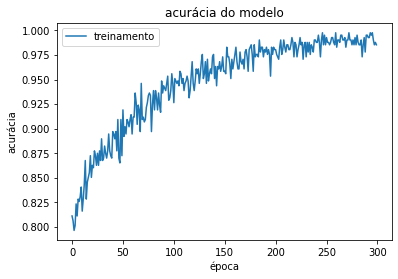

In [22]:
# print(history.history['loss'])
plt.plot(history.history['acc'])
# plt.plot(history.history['loss'])
plt.title('acurácia do modelo')


plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treinamento'], loc='upper left')
plt.show()

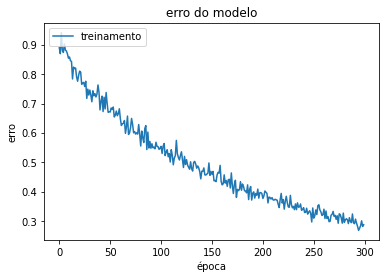

In [25]:
# print(history.history['loss'])
# plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('erro do modelo')
plt.ylabel('erro')
plt.xlabel('época')
plt.legend(['treinamento'], loc='upper left')
plt.show()

In [24]:
test_predictions = np.argmax(model.predict(X_data_test), axis=-1)
# Comparing the predictions to actual forest cover types for the test rows
# test is the data right after splitting into train, test and val (shuffle was false in dataset so the order will match)
print(classification_report(Y_data_test,test_predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00        12
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        11
           4       0.85      1.00      0.92        11
           5       1.00      1.00      1.00        12
           6       0.88      0.78      0.82         9
           7       1.00      0.78      0.88         9
           8       1.00      0.89      0.94         9
           9       0.82      1.00      0.90         9

    accuracy                           0.94       102
   macro avg       0.94      0.94      0.94       102
weighted avg       0.95      0.94      0.94       102



# Validação do modelo

In [62]:
model.evaluate(X_data_test, Y_data_test)

4/4 [==============================] - 0s 22ms/step - loss: 0.5980 - acc: 0.9608 - f1_m: 4.0767 - precision_m: 2.6454 - recall_m: 9.0961


In [48]:
model.test_on_batch(X_data_test, Y_data_test)

In [51]:
print(model.metrics_names)

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']


# Predição do modelo

In [12]:
prediction = model.predict(np.expand_dims(X_data_test[0], axis=0))[0]
print(Y_data_test)
for predict, name in zip(prediction, class_names):
    print(
        "%.2f ==> %s"
        % ((100 * predict), name)
    )

[0 0 0 0 0 0 1 1 1 1 1 1]
58.24 ==> A
18.79 ==> B


# Salvar o modelo

In [ ]:
model.save('./model/')

# Carregar o modelo

In [26]:
newModel = keras.models.load_model('./model/')

In [27]:
newModel.evaluate(X_data_test, Y_data_test)

4/4 [==============================] - 0s 20ms/step - loss: 0.5835 - acc: 0.9412


[0.5835137963294983, 0.9411764740943909]